<a href="https://colab.research.google.com/github/Gabriel-Barboza/Denoising-Autoencoder-/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instala dependências**

In [ ]:
!pip install pillow scikit-image matplotlib scikit-learn tensorflow

**Cria o drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extrai os arquivos**

In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/gh/pasta2.zip'
extract_dir = '/content/imagens'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Imagens extraídas para {extract_dir}")

Imagens extraídas para /content/imagens


**Varáveis globais**

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (96, 96)
IMG_DIR = '/content/imagens/pasta2'
NOISE_TYPES = ['gaussian', 'salt', 'pepper', 's&p', 'speckle']
RESULT_DIR = "resultados"

**Carrega imagens do diretório**

In [ ]:
def load_images(img_dir, img_size):
    imgs = []
    for filename in os.listdir(img_dir):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):
            img_path = os.path.join(img_dir, filename)
            img = Image.open(img_path).convert('RGB').resize(img_size)
            img = np.array(img) / 255.0
            imgs.append(img)
    return np.array(imgs)

print("Carregando imagens...")
images = load_images(IMG_DIR, IMG_SIZE)
print(f"Total de imagens carregadas: {len(images)}")

Carregando imagens...
Total de imagens carregadas: 6232


**Limita o número de imagens para treino**

In [ ]:
N = 3000
if len(images) > N:
   images = images[:N]
   print(f"Usando apenas as primeiras {N} imagens para teste rápido.")

Usando apenas as primeiras 3000 imagens para teste rápido.


**Adiciona ruído nas imagens**

In [ ]:
x_train, x_test = train_test_split(images, test_size=0.15, random_state=42)
def add_random_noise(images):
    noisy_imgs = []
    for img in images:
        noise_type = np.random.choice(['gaussian', 'salt'])
        if noise_type == 'gaussian':
            noisy = random_noise(img, mode='gaussian', var=0.01)
        else:
            noisy = random_noise(img, mode='salt', amount=0.08)
        noisy_imgs.append(np.clip(noisy, 0., 1.))
    return np.array(noisy_imgs)

print("Adicionando ruídos às imagens...")
x_train_noisy = add_random_noise(x_train)
x_test_noisy = add_random_noise(x_test)

Adicionando ruídos às imagens...


**Construindo o autoencoder**

In [ ]:
def build_autoencoder(img_size):
    input_img = keras.Input(shape=(*img_size, 3))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    return autoencoder

autoencoder = build_autoencoder(IMG_SIZE)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
print("x_train_noisy shape:", x_train_noisy.shape)
print("x_train shape:", x_train.shape)
print("x_test_noisy shape:", x_test_noisy.shape)
print("x_test shape:", x_test.shape)
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=5,
    batch_size=8,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

print("Gerando imagens denoised...")
x_test_denoised = autoencoder.predict(x_test_noisy)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,011 (43.01 KB)

 Trainable params: 11,011 (43.01 KB)

 Non-trainable params: 0 (0.00 B)

x_train_noisy shape: (2550, 96, 96, 3)
x_train shape: (2550, 96, 96, 3)
x_test_noisy shape: (450, 96, 96, 3)
x_test shape: (450, 96, 96, 3)
Epoch 1/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 76s 234ms/step - loss: 0.0280 - val_loss: 0.0050
Epoch 2/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 84s 230ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 81s 227ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - loss: 0.0034 - val_loss: 0.0033
Gerando imagens denoised...
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step


**Mostra o resultado**

Imagens de resultado salvas em: resultados


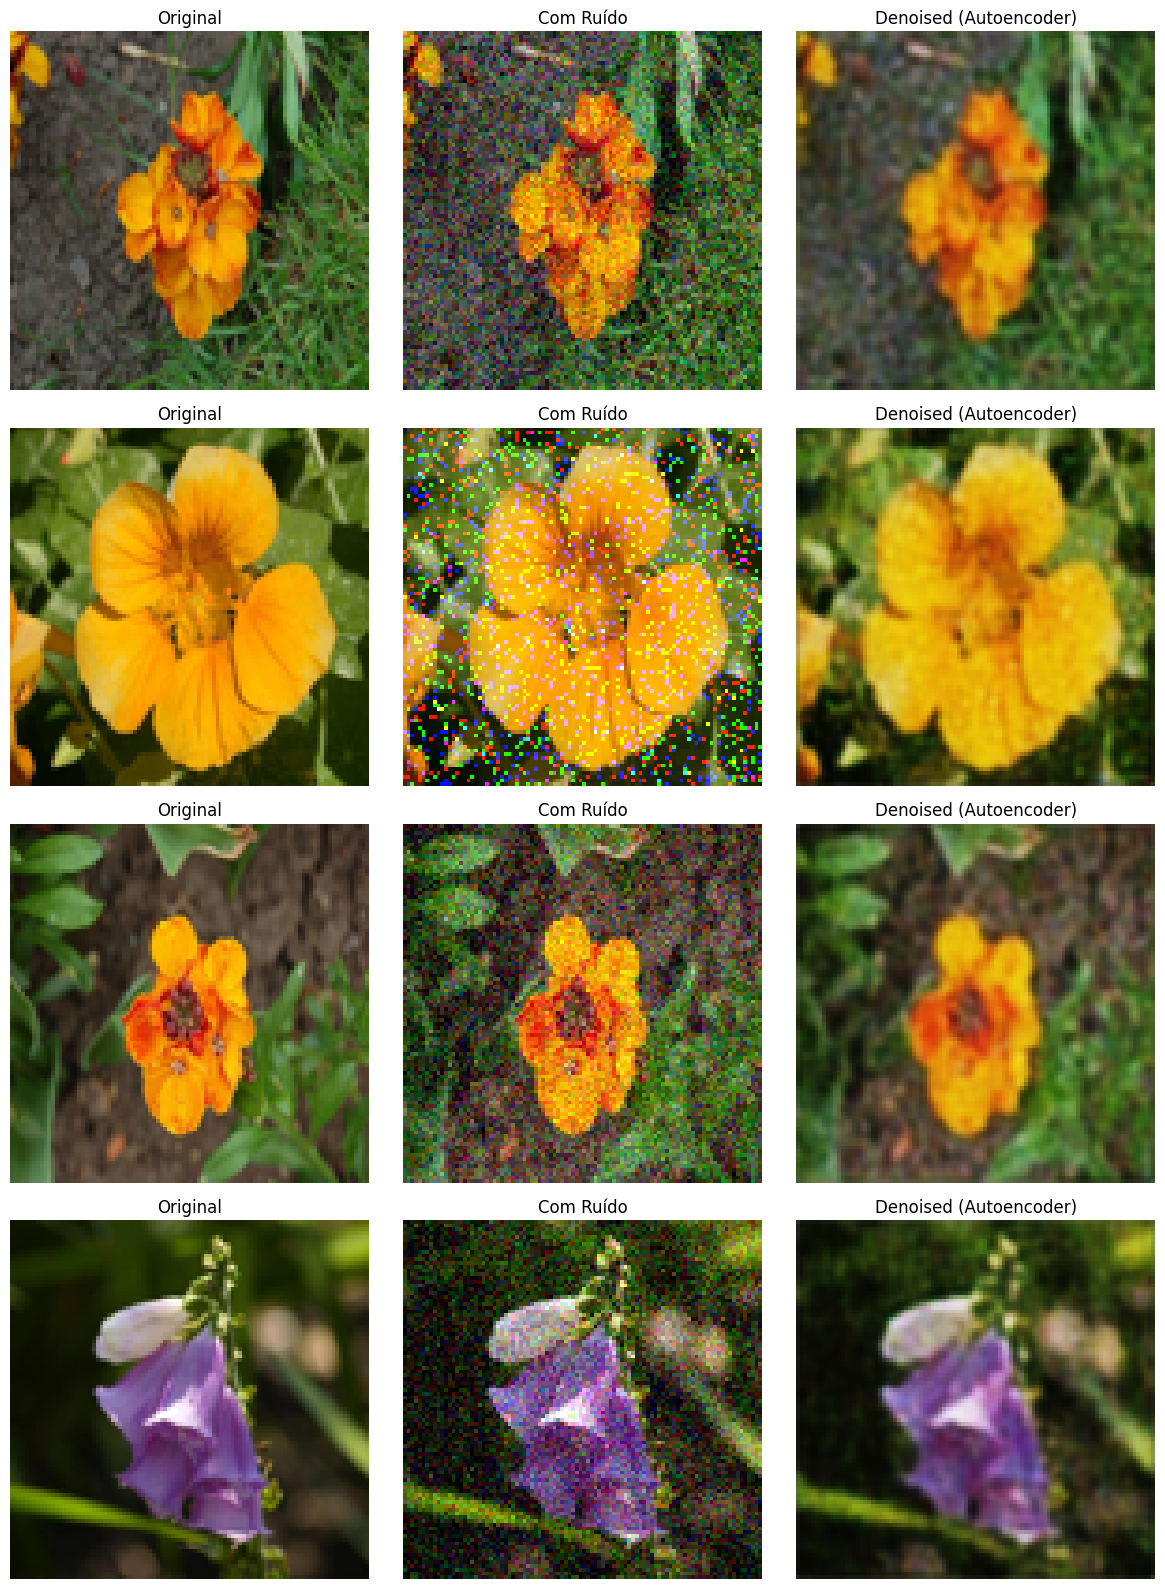

In [ ]:
os.makedirs(RESULT_DIR, exist_ok=True)
for i in range(15):
    orig = (x_test[i] * 255).astype(np.uint8)
    noisy = (x_test_noisy[i] * 255).astype(np.uint8)
    denoised = (x_test_denoised[i] * 255).astype(np.uint8)
    Image.fromarray(orig).save(f"{RESULT_DIR}/orig_{i}.png")
    Image.fromarray(noisy).save(f"{RESULT_DIR}/noisy_{i}.png")
    Image.fromarray(denoised).save(f"{RESULT_DIR}/denoised_{i}.png")

print(f"Imagens de resultado salvas em: {RESULT_DIR}")

def plot_results(x_test, x_test_noisy, x_test_denoised, num=4):
    fig, axs = plt.subplots(num, 3, figsize=(12, 4*num))
    for i in range(num):
        axs[i, 0].imshow(x_test[i])
        axs[i, 0].set_title('Original')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(x_test_noisy[i])
        axs[i, 1].set_title('Com Ruído')
        axs[i, 1].axis('off')
        axs[i, 2].imshow(x_test_denoised[i])
        axs[i, 2].set_title('Denoised (Autoencoder)')
        axs[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

idxs = np.random.choice(len(x_test), size=4, replace=False)
plot_results(x_test[idxs], x_test_noisy[idxs], x_test_denoised[idxs], num=4)

**Baixa o resultado**

In [ ]:
from google.colab import files
import shutil


shutil.make_archive("resultados", 'zip', "resultados")
files.download("resultados.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Escolhe uma imagem para usar a I.A treinada**

In [ ]:
from google.colab import files
uploaded = files.upload()

import os
img_filename = next(iter(uploaded))
print(f"Imagem enviada: {img_filename}")

Saving ruido_image_08120.jpg to ruido_image_08120.jpg
Imagem enviada: ruido_image_08120.jpg


**Aplica o noise e denoise na imagem escolhida**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


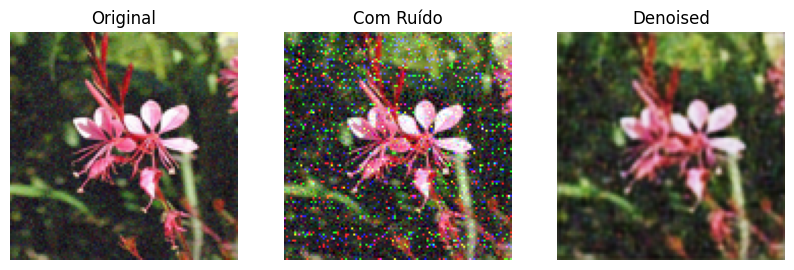

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise

IMG_SIZE = (112, 112)

img = Image.open(img_filename).convert('RGB').resize(IMG_SIZE)
img_np = np.array(img) / 255.0

noisy_img = add_random_noise(img_np)

input_noisy = np.expand_dims(noisy_img, axis=0)

denoised = autoencoder.predict(input_noisy)
denoised_img = np.clip(denoised[0], 0, 1)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(noisy_img)
plt.title('Com Ruído')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(denoised_img)
plt.title('Denoised')
plt.axis('off')

plt.show()

**Aplica o denoise em uma imagem escolhida**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


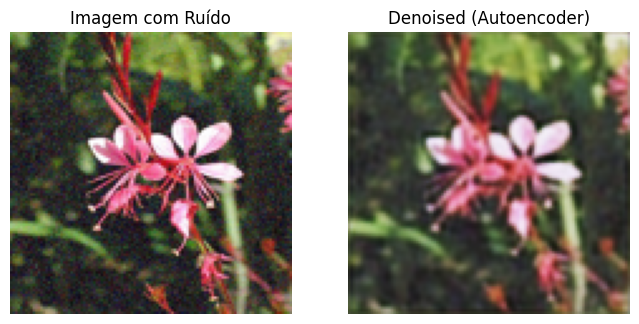

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (112, 112)

img = Image.open(img_filename).convert('RGB').resize(IMG_SIZE)
img_np = np.array(img) / 255.0

input_img = np.expand_dims(img_np, axis=0)


denoised = autoencoder.predict(input_img)
denoised_img = np.clip(denoised[0], 0, 1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title('Imagem com Ruído')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(denoised_img)
plt.title('Denoised (Autoencoder)')
plt.axis('off')
plt.show()